In [312]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve

In [194]:
data = pd.read_excel('Data/Formatted_Small_V5_segments.xlsx')
data_n = pd.read_excel('Data/Small_V5_tracks.xlsx')
data.columns = ['trash', 'id', 'time', 'x', 'y', 'z']
data = data[['id', 'time', 'x', 'y', 'z']]

In [195]:
cells = sorted(list(set(data['id'])))
times = sorted(list(set(data['time'])))

In [196]:
types = []
for n in data_n['Name']:
    d = n.split('_')
    if len(d) < 2:
        types.append('TrackUnif')
    else:
        types.append(d[1])
        
t_list = set(types)
t_dict = {t: i for i, t in enumerate(t_list)}
type_ints = [t_dict[t] for t in types]
data_n['Type'] = type_ints

In [197]:
format_data = np.zeros((len(cells), 3*len(times)))
format_data.shape

(1189, 630)

In [198]:
print(t_dict)

{'SYN': 0, 'DEAD': 1, 'UNINF': 2, 'MONO': 3}


In [199]:
def format_cell(cell, num_back=10):
    """
    Creates a matrix of `num_back` length paths from `cell`s data.
    If a cell has fewer than `num_back` time points, it discards the data.
    If a cell has more than `num_back` time points, each `num_back` length
    path constitutes one row in the returned matrix
    
    cell: the cell id
    num_back: the path length
    
    returns: ds, the path matrix with 3*num_back columns
    """
    d = data[data['id'] == cell]
    ts = sorted(d['time'])
    ds = np.zeros((len(ts)//num_back + 1, num_back*3 + 1))
    for i, t in enumerate(ts):
        if d[d['time'] == t][['x', 'y', 'z']].to_numpy().shape[0] > 1:
            print(d[d['time'] == t][['x', 'y', 'z']].to_numpy().shape)
            continue
        ds[i//num_back, i%num_back*3:i%num_back*3+3] = d[d['time'] == t][['x', 'y', 'z']].to_numpy()
    for i in range(ds.shape[0]):
        ofs = ds[i, 0:3]
        for j in range(num_back):
            ds[i, 3*j:3*j+3] = ds[i, 3*j:3*j+3] #- ofs
    ds[:,-1] = data_n[(data_n['Id'] == cell)]['Type']
    if ds[-1,-2] == 0:
        return ds[:-1, :]
    return ds
        
    
#format_cell(1262868), data[data['id'] == 1262868]

In [200]:
# creating a the matrix of paths to train models on

num_back = 10
cell_arrays = []
for c in cells:
    times = data[data['id'] == c]['time']
    r = max(times) - min(times)
    if r < 4*num_back:
        continue
    cell_arrays.append(format_cell(c, num_back))
    

In [201]:
fmt_data = np.vstack(cell_arrays)
fmt_data.shape

(11027, 31)

In [359]:
mask = fmt_data[:,-1] != t_dict['DEAD']
fmt_data = fmt_data[mask, :]
fmt_data.shape

(9584, 31)

In [360]:
# y is the last point in the path. X is the first num_back - 1 points
# X,y = fmt_data[:, :-4], fmt_data[:, -3:-1]

X, y = fmt_data[:, :-1], fmt_data[:, -1]

In [361]:
y = y.astype(np.int32)
y = y == 2

In [369]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [363]:
train = np.hstack((x_train, np.atleast_2d(y_train).T))

In [364]:
t_os = train[np.where(train[:, -1] == 0)]
t_3s = train[np.where(train[:, -1] == 3)]

In [374]:
train = np.vstack((train, t_os, t_3s, t_os, t_3s, t_os, t_3s, t_os, t_3s))
np.random.shuffle(train)

In [375]:
x_train, y_train = train[:, :-1], train[:,-1]

In [376]:
rgr = RandomForestClassifier(oob_score=True)

In [377]:
rgr.fit(x_train, y_train)

RandomForestClassifier(oob_score=True)

In [378]:
preds = rgr.predict(x_test)
rgr.score(x_test, y_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       278
        True       1.00      0.99      1.00      2118

    accuracy                           0.99      2396
   macro avg       0.98      0.99      0.98      2396
weighted avg       0.99      0.99      0.99      2396



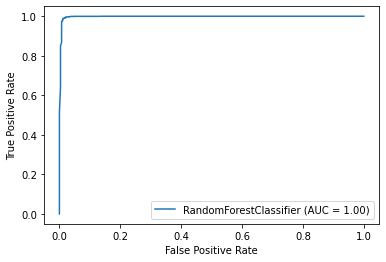

In [379]:
plot_roc_curve(rgr, x_test, y_test)

In [346]:
dtr = DecisionTreeClassifier()
dtr.fit(x_train, y_train)

DecisionTreeClassifier()

In [347]:
preds = dtr.predict(x_test)
dtr.score(x_test,y_test), mse(preds, y_test)

(0.9344741235392321, 0.06552587646076795)

In [258]:
dtr.get_depth()

22

In [259]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
preds = lr.predict(x_test)
lr.score(x_test, y_test), mse(preds, y_test)

/Users/tim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(0.7671381936887922, 0.30431628581791803)

In [380]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [381]:
BATCH_SIZE = 256
n_features = 30
n_classes=len(t_list)
training_dataset = TensorDataset(torch.from_numpy(x_train).float(), 
                                 torch.from_numpy(y_train).long())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(x_test).float(), 
                                torch.from_numpy(y_test).long())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [397]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=64, p_dropout=0.5):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden, bias=True)
        self.fc2 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc3 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc4 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc5 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc6 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc7 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc8 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc9 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc10 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc11 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc12 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc13 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc14 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc15 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.fc16 = nn.Linear(n_hidden, n_classes, bias=True)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        #x = nn.ReLU()(self.fc5(x))
        #x = nn.ReLU()(self.fc6(x))
        #x = nn.ReLU()(self.fc7(x))
        #x = nn.ReLU()(self.fc8(x))
        #x = nn.ReLU()(self.fc9(x))
        #x = nn.ReLU()(self.fc10(x))
        #x = nn.ReLU()(self.fc11(x))
        #x = nn.ReLU()(self.fc12(x))
        #x = nn.ReLU()(self.fc13(x))
        #x = nn.ReLU()(self.fc14(x))
        #x = nn.ReLU()(self.fc15(x))
        x = self.fc16(x)
        x = torch.log_softmax(x, dim=1)
        return x

In [398]:
def loader_accuracy(model, test_loader, lf=nn.NLLLoss()):
    lossies = []
    accs = []
    #grab a batch from the test loader
    with torch.no_grad():
        for examples, labels in test_loader:
            torch.cuda.empty_cache()
            outputs = model.forward(examples)
            lossies.append(lf(torch.squeeze(outputs), torch.squeeze(labels)).item())

            #for each output in the batch, check if the label is correct
            preds = np.argmax(outputs.detach().numpy(), axis=1)
            labels = labels.detach().numpy()
            accuracy = (preds == labels).mean()
            accs.append(accuracy)

    loss = sum(lossies)/len(lossies)
    acc = sum(accs)/len(accs)

    return acc, loss

In [399]:
def train(epochs=20):
    # reset the model
    model = Classifier(n_features=n_features, n_classes=len(set(y_test)))
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.001)

    for epoch in range(epochs):
        losses = []

        for x_batch_train, y_batch_train in train_loader:
            optimizer.zero_grad()
            
            outputs = model.forward(x_batch_train)
            loss = criterion(outputs, y_batch_train)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())
    
        if epoch % 10 == 0:
            print(np.mean(losses))
            print(loader_accuracy(model, test_loader))
        
    return model

In [400]:
m = train(200)

1.0960009
(0.1948784722222222, 0.7554156846470303)
0.6623714
(0.2608506944444444, 0.809357742468516)
0.65122664
(0.4887152777777778, 0.7224977413813273)
0.6269263
(0.4370659722222222, 0.756029811170366)
0.60217303
(0.5221354166666666, 0.6522340774536133)
0.5870463
(0.5434027777777778, 0.6662152740690443)
0.56847405
(0.6380208333333334, 0.5762496656841702)
0.54774904
(0.5260416666666666, 0.7471619976891412)
0.5377645
(0.4175347222222222, 0.8324476546711392)
0.51795805
(0.6176215277777778, 0.6197690036561754)
0.49853438
(0.5720486111111112, 0.6844008631176419)
0.47058955
(0.6983506944444444, 0.5224905874994066)
0.45636255
(0.7400173611111112, 0.49046015408304)
0.41842306
(0.7287326388888888, 0.4814263615343306)
0.40186334
(0.7265625, 0.48826080560684204)
0.39234385
(0.7552083333333334, 0.4611557920773824)
0.35715273
(0.7638888888888888, 0.48768897851308185)
0.35385692
(0.6853298611111112, 0.6053784886995951)
0.34430552
(0.7964409722222222, 0.3951825698216756)
0.3596293
(0.836805555555555

In [401]:
vals = m(torch.Tensor(x_test))

In [402]:
preds = torch.argmax(vals,dim=1).numpy()

In [403]:
sum(preds == y_test)/len(y_test)

0.827212020033389

In [404]:
[sum(y_test == i) for i in range(4)]

[278, 2118, 0, 0]

In [405]:
2129/len(y_test)

0.8885642737896494

In [406]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.38      0.79      0.52       278
        True       0.97      0.83      0.89      2118

    accuracy                           0.83      2396
   macro avg       0.68      0.81      0.71      2396
weighted avg       0.90      0.83      0.85      2396

